# Machine learning model area of applicability

Once a machine learning model has been trained, it is important to assess where it can be used to generate predicted maps. Machine learning models learn relationships between predictor variables and target values using a training dataset. The model should only be used to generate predictions in locations where the learnt relationships between predictor variables and target values hold. Before using a model, we need to identify the area where the model is applicable given its training data. Relatedly, a model is evaluated using a performance metric (e.g. root mean squared error (RMSE)). We also need to know for what area that estimate of model error is applicable how model error varies with increasing distance from locations covered in the training data.  

A paper by <a href="https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.13650" target="_blank">Meyer and Pebesma (2021)</a> addresses these issues and presents a method for computing the area of applicability for a machine learning model. Their method computes a dissimilarity index measuring the distance between the values of predictor variables in a candidate location for prediction using the model and values of predictor variables in the model's training dataset. If the dissimilarity index value is greater than a threshold it is deemed outside the model's area of applicability. They also present a cross-validation method for assessing the relationship between dissimilarity index values and model error. 

This notebook steps through the methods presented by <a href="https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.13650" target="_blank">Meyer and Pebesma (2021)</a> and demonstrates how we can compute the area of applicability for a machine learning model that predicts plant species richness from bioclimatic and elevation variables that was trained on data collected at points across South America. 

## Setup

### Load data

In [2]:
import os
import subprocess

if "data-geoml" not in os.listdir(os.getcwd()):
    subprocess.run('wget "https://github.com/envt-5566/geo-ml/raw/main/data/data-geoml.zip"', shell=True, capture_output=True, text=True)
    subprocess.run('unzip "data-geoml.zip"', shell=True, capture_output=True, text=True)
    if "data-geoml.zip" not in os.listdir(os.getcwd()):
        print("Has a directory called data-geoml been downloaded and placed in your working directory? If not, try re-executing this code chunk")
    else:
        print("Data download OK")

DATA_PATH = os.path.join(os.getcwd())

Data download OK


### Load packages

In [53]:
if 'google.colab' in str(get_ipython()):
    !pip install xarray[complete]
    !pip install rioxarray
    !pip install mapclassify
    !pip install contextily
    !pip install pysal

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from math import log
from tqdm import tqdm

# plotting
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt

# pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans

## Dissimilarity Index

The dissimilarity index is a measure of the distance between a candidate location for prediction using the machine learning model and the model's training data. It measures distance in predictor variable space and is a measure of how similar the predictor variable values are to the most similar example in the training dataset. The process to compute the dissimilarity index is:

1. Compute the Euclidean distance between the predictor variables for the candidate location and every example in the training dataset.
2. Select the minimum distance.
3. Compute the average Euclidean distance between predictor variables for all examples in the training dataset.
4. Divide the minimum distance between the candidate prediction location and the training dataset (2) by the average distance between predictor variables in the training dataset (3).

The dissimilarity index for the candidate prediction location is the result of step 4. Standardising the dissimilarity index values by dividing by the average distance between predictor variables in the training dataset means that dissimilarity index values range from 0 to infinity. If the dissimilarity index value is 0 then the candidate prediction location is identical to an example in the training dataset.

The following is a helper function that implements steps 2.1, 2.3 and 2.4 in Meyer and Pebesma (2021) and computes the dissimilarity index given arrays of predictor variables for the training dataset and candidate predictor locations.  

In [17]:
def compute_di(X_train, X_preds, dbar, scaled):
    """Compute the Dissimilarity Index (DI).

    This is based on steps 2.1, 2.3, and 2.4 in Meyer and Pebesma (2021).

    Note, we omit the weighting of predictor variables (step 2.2 of Meyer and Pebesma (2021).
    
    We implement the steps explicitly (i.e. using for loops rather than NumPy broadcasting
    and linear algebra operations). This is for education purposes to support understanding how
    DI is computed. 

    Args:
        X_train (ndarray): Array of training data where examples are aligned on the 0 axis and features on the 1 axis.
        X_preds (ndarray): Array of predictor data where examples are aligned on the 0 axis and features on the 1 axis.
        dbar (float | None): Precomputed mean of dissimilarity index for all values in the training dataset.
        scaled (bool): Flag to indicate if input data is already standardised.

    Returns:
        ndarray, an array of DI values for each example in the prediction set. 
    """
    
    # standardise predictors (using training data)
    if scaled:
        X_train_scaled = X_train
        X_preds_scaled = X_preds
    else:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_preds_scaled = scaler.transform(X_preds)

    # Compute dissimilarity index (DI)
    # Section 2.3 in Meyer and Pebesma (2021)
    
    # create a matrix to store Euclidean distance between 
    # all training points and prediction points
    n_X_train = X_train_scaled.shape[0]
    n_X_preds = X_preds_scaled.shape[0]

    d_arr = np.zeros((n_X_train, n_X_preds))

    for r in range(0, n_X_train):
        x_train = X_train_scaled[r, :]
        for c in range(0, n_X_preds):
            x_preds = X_preds_scaled[c, :]
            # compute Euclidean distance
            x_dist = np.sqrt(np.sum((x_train - x_preds) * (x_train - x_preds)))
            # store Euclidean distance in d_arr
            d_arr[r, c] = x_dist
            
    # get the minimum distance between each point in x_preds
    # and the training set
    d_arr = np.min(d_arr, axis=0)
    
    # Section 2.4 in Meyer and Pebesma (2021)
    if dbar:
        di = d_arr / dbar
    else:
        # compute average distance between all
        # training points to standardise DI
        d_train_arr = []
        for r in range(0, n_X_train):
            x_train_1 = X_train_scaled[r, :]
            for c in range(r+1, n_X_train):
                x_train_2 = X_train_scaled[c, :]
                # compute Euclidean distance
                x_dist = np.sqrt(np.sum((x_train_1 - x_train_2) * (x_train_1 - x_train_2)))
                # store Euclidean distance in d_arr
                d_train_arr.append(x_dist)
    
        di = d_arr / np.mean(d_train_arr)

    return di

In [18]:
def compute_dbar(X_train, scaled):
    """Compute average DI between all values in the training dataset.
    
    d_bar is computed section 2.4 in Meyer and Pebesma (2021). It is 
    used to standardise dissimilarity index values. 

    Precomputing can save time when the training dataset is fixed and we
    want to iterate over a range of candidate prediction locations.

    We implement the steps explicitly (i.e. using for loops rather than NumPy broadcasting
    and linear algebra operations). This is for education purposes to support understanding how
    dbar is computed. 
    """
    # standardise predictors (using training data)
    if scaled:
        X_train_scaled = X_train
    else:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)

    n_X_train = X_train.shape[0]
        
    # Section 2.4 in Meyer and Pebesma (2021)
    
    # compute average distance between all
    # training points to standardise DI
    d_train_arr = []
    for r in range(0, n_X_train):
        x_train_1 = X_train_scaled[r, :]
        for c in range(r+1, n_X_train):
            x_train_2 = X_train_scaled[c, :]
            # compute Euclidean distance
            x_dist = np.sqrt(np.sum((x_train_1 - x_train_2) * (x_train_1 - x_train_2)))
            # store Euclidean distance in d_arr
            d_train_arr.append(x_dist)
            
    return np.mean(d_train_arr)

## Dissimilarity index threshold

Meyer and Pebesma (2021) in section 2.5 compute a dissimilarity index threshold which represents the outlier removed maximum dissimilarity of the training dataset. This represents a threshold for the model's area of applicability. If a candidate prediction location has a dissimilarity index greater than this threshold it is deemed outside the model's area of applicability. 

The dissimilarity index threshold is computed using k-fold cross-validation on the training dataset:

1. Split the training dataset into $k$ folds.
2. Hold out each $k$ fold in-turn:
    * Compute the dissimilarity index between all values in the hold-out fold and training folds.
    * Optional step: Compute model predictions and error for all values in the hold-out fold.
3. Compute the outlier-removed threshold as the 75th percentile dissimilarity index value + (1.5 * IQR)

The following helper function computes the dissimilarity index threshold given the training data as a `GeoDataFrame`. 

In [19]:
def compute_di_theshold(gdf, n_folds, model, spatial_cv, target_column, cols_to_drop):
    """
    Function to compute DI threshold following Meyer and Pebesma (2021).

    The DI threshold is computed as the 75th percentile + (1.5 * IQR). DI threshold is 
    considered the outlier removed maximum DI of the training data set. Data points with a 
    DI greater than the DI threshold are outside the area of applicability of the model
    given the training data. 

    We implement the steps explicitly (i.e. using for loops rather than NumPy broadcasting
    and linear algebra operations). This is for education purposes to support understanding how
    the DI threshold is computed. 
    
    Args:
        gdf (GeoDataFrame): The spatial dataset (GeoDataFrame) containing features and the target variable.
        n_folds (int): The number of folds to use for cross-validation.
        model: The machine learning model to train and evaluate.
        spatial_cv (bool): If `True`, use k-fold spatial cross-validation. Otherwise, use k-fold random cross-validation.
        target_column (str): The column name for the target variable.
        cols_to_drop (list): Columns to drop that should not be included as predictors.

    Returns:
        dict, dict object with the DI threshold, the DI values for the hold out folds, the errors
        for the hold out folds, and the predictions for the hold out folds.
    
    """
    # Section 2.5 in Meyer and Pebesma (2021)
    if spatial_cv:
        gdf_tmp = gdf.copy()

        # split the data into n_folds spatially
        # assign a fold id column to each row
    
        # add x and y columns
        gdf_tmp.loc[:, "x"] = gdf_tmp.loc[:, "geometry"].x
        gdf_tmp.loc[:, "y"] = gdf_tmp.loc[:, "geometry"].y
    
        # create an array of x and y values
        X = gdf_tmp.loc[:, ["x", "y"]].copy()
    
        # create a KMeans clusterer
        km = KMeans(
            n_clusters=n_folds,
            init="random",
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=123,
        )
        spatial_folds = km.fit_predict(X)
        gdf_tmp.loc[:, "fold"] = spatial_folds
    
        # keep a copy of GeoDataFrame with folds for plotting
        gdf_spatial_folds = gdf_tmp.copy()

        # drop columns that should not be included as predictors
        gdf_tmp = gdf_tmp.drop(columns=cols_to_drop)
        
    else:
        gdf_tmp = gdf.copy()

        # split the data into n_folds
        # assign a fold id column to each row
        # shuffle the GeoDataFrame
        gdf_tmp = gdf_tmp.sample(frac=1, random_state=123)
        
        # assign a fold id using the modulo operation
        gdf_tmp.loc[:, "fold"] = np.arange(len(gdf_tmp)) % n_folds
        
        # store shuffled gdf to return for plotting
        gdf_folds = gdf_tmp.copy()

        # drop columns that should not be included as predictors
        gdf_tmp = gdf_tmp.drop(columns=cols_to_drop)

    # list to store DI's computed on the hold out folds
    dis = []

    # predictions on cv hold out folds
    predictions = []
    
    # errors on cv hold out folds
    errors = []
    
    # loop over folds and compute DI
    for k in range(0, n_folds):
        # subset out preds fold
        gdf_preds_fold = gdf_tmp.loc[gdf_tmp["fold"] == k, :]
        
        # subset out training folds
        # != is the not equals to operator
        gdf_train_fold = gdf_tmp.loc[gdf_tmp["fold"] != k, :]

        # subset training folds into predictors and targets arrays
        X_train = gdf_train_fold.drop(columns=[target_column, "fold"])
        y_train = gdf_train_fold.loc[:, target_column]

        # subset preds fold into predictors and targets arrays
        X_preds = gdf_preds_fold.drop(columns=[target_column, "fold"])
        y_preds = gdf_preds_fold.loc[:, target_column]

        # standardise data
        tmp_scaler = StandardScaler().fit(X_train)
        X_train_scaled = tmp_scaler.transform(X_train)
        X_preds_scaled = tmp_scaler.transform(X_preds)

        # use compute_df function previously defined
        fold_dis = compute_di(X_train_scaled, X_preds_scaled, None, scaled=True)

        dis = dis + fold_dis.tolist()

        # train model 
        if model:
            m = model.fit(X_train_scaled, y_train)
    
            # compute predictions and error using the hold out fold 
            y_test_preds = m.predict(X_preds_scaled)
            predictions = predictions + y_test_preds.tolist()
    
            y_preds_errors = y_test_preds - y_preds
            errors = errors + y_preds_errors.tolist()

    # compute DI threshold
    # 75th percentile 1.5 * IQR as in Meyer and Pebesma (2021)
    iqr = np.percentile(dis, 75) - np.percentile(dis, 25)
    di_threshold = np.percentile(dis, 75) + (1.5 * iqr)

    output = {}
    output["di_threshold"] = di_threshold
    output["di"] = dis
    output["targets"] = y_preds
    output["predictions"] = predictions
    output["errors"] = errors

    return output

## Compute the area of applicability

We will compute the area of applicability for a machine learning model that predicts plant species richness at a location using bioclimatic variables and elevation as predictors. Let's load the labelled data and predictors and plot them on a web map. You can see the points are not evenly distributed across South America; this should raise concerns about the ability of the model to generate predictions in locations far away from the training data. To assess where we can use a machine learning model trained on this data to predict species richness, we'll compute the area of applicability for this model. Here, we'll focus on assessing which locations within Chile and parts of Agrentina are applicable for mapping using our model. 

This is the dataset presented in <a href="https://arxiv.org/html/2404.06978v1" target="_blank">Meyer et al. (2024)</a> that includes points across South America representing vegetation surveys where species richness counts were recorded from the <a href="https://onlinelibrary.wiley.com/doi/10.1111/geb.13346" target="_blank">sPlotOpen database</a>. Species richness counts are the target values. Predictor variables included with this dataset are <a href="https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_BIO#bands" target="_blank">WorldClim bioclimatic variables</a> and elevation. The bioclimatic variables have the following definitions:

* BIO1: Annual Mean Temperature
* BIO2: Mean Diurnal Range (Mean of monthly (max temp - min temp))
* BIO3: Isothermality (BIO2/BIO7) (×100)
* BIO4: Temperature Seasonality (standard deviation ×100)
* BIO5: Max Temperature of Warmest Month
* BIO6: Min Temperature of Coldest Month
* BIO7: Temperature Annual Range (BIO5-BIO6)
* BIO8: Mean Temperature of Wettest Quarter
* BIO9: Mean Temperature of Driest Quarter
* BIO10: Mean Temperature of Warmest Quarter
* BIO11: Mean Temperature of Coldest Quarter
* BIO12: Annual Precipitation
* BIO13: Precipitation of Wettest Month
* BIO14: Precipitation of Driest Month
* BIO15: Precipitation Seasonality (Coefficient of Variation)
* BIO16: Precipitation of Wettest Quarter
* BIO17: Precipitation of Driest Quarter
* BIO18: Precipitation of Warmest Quarter
* BIO19: Precipitation of Coldest Quarter

Let's start by loading and mapping the training data. 

In [20]:
gdf = gpd.read_file(os.path.join(DATA_PATH, "plant_species_south_america.gpkg"))

In [21]:
gdf.explore(column="Species_richness")

Let's now load some predictor variables which we we'd like to feed into our machine learning model to generate a predicted map of plant species richness. The predictor variables are stored as raster format data. Each predictor variable is stored as an array of pixels with each pixel representing a location of the Earth's surface. The predictor variables that we'll load here cover Chile and parts of Argentina and are stored in a GeoTIFF file. 

We'll load the GeoTIFF file into our program as an xarray `DataArray`. 

### Quick aside: Xarray

Xarray is a Python package that builds on top of NumPy's array-based data structures, but provides extra tools and functions that are useful for working with geospatial and Earth Science datasets. For example, `xarray.DataArray` data structures are objects that store multidimensional arrays of raster values and also store metadata information that describe the raster values. 

Xarray also provides convenient functions for reading raster data from geospatial data files on disk into memory as `xarray.DataArray` objects which we can use in our Python programs while retaining geographic and temporal information about the raster values stored in the array.

Specifically, while a NumPy `ndarray` stores just the raster values and has some properties such as the `shape` (number of elements along each axis) and `ndim` (the dimensions of the array) it does not explicitly store any geospatial, temporal, or other geographic metadata. `xarray` solves this problem by reading raster data into an `xarray.DataArray` object with:

* `values`: the multidimensional array of raster values
* `dims`: a list of names for the dimensions of the array (e.g. instead of axis 0 describing the 0th (row) dimension of an array, that dimension can have a descriptive label such as longitude)
* `coordinates`: a `list` of array-like objects that describe the location of an array element along that dimension (e.g. a 1D array of longitude values describing the location on the Earth's surface for each row in the array)
* `attrs`: a `dict` of metadata attributes describing the dataset

`xarray.DataArray` objects can be stored within a larger container called `xarray.Dataset`. An `xarray.Dataset` can store many `xarray.DataArray` objects that share `dims` and `coordinates`. This is useful if you have different arrays of different `Variables` that correspond to the same locations and time-periods (e.g. you could have a separate array for temperature and precipitation values organised within a single `xarray.Dataset`).

![](https://docs.xarray.dev/en/stable/_images/dataset-diagram.png)

*Schematic of an xarray.Dataset (source: xarray Getting Started)*

**Why is Xarray useful for geospatial data?** 

* The `dims` and `coordinates` of an `xarray.DataArray` mean we can subset values from an array using latitude, longitude, time, or whatever a coordinate describes; we're not just restricted to subsetting values based on their index location within an array
* `xarray.Dataset` objects provide a container to store multidimensional arrays (e.g. many variables and time points) that are common in geography, Earth Sciences, meteorology, and agriculture. For example, multispectral satellite images of the same location over time; arrays of different meteorological variables)
* useful functions for reading, analysing and visualising raster or array-like geospatial data that are common across many spatial data science workflows

### Data input

The `rioxarray` package provides tools for reading and writing raster geospatial data files into `xarray.DataArray` objects.

Let's pass the path to a GeoTIFF file of raster data into the `rioxarray` `open_rasterio()` function:

In [22]:
preds_path = os.path.join(DATA_PATH, "chile_predictors.tif")
xds = rxr.open_rasterio(preds_path)

We have used `rioxarray` to read raster data stored in a GeoTIFF file into our program as an `xarray.DataArray` object referenced by the variable `xds`. We can print the `xarray.DataArray` object to inspect its metadata. 

In [23]:
xds

<xarray.DataArray (band: 11, y: 454, x: 127)> Size: 3MB
[634238 values with dtype=float32]
Coordinates:
  * band         (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 1kB -76.21 -76.12 -76.04 ... -65.87 -65.79 -65.71
  * y            (y) float64 4kB -17.37 -17.46 -17.54 ... -54.96 -55.04 -55.12
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('bio_1', 'bio_4', 'bio_5', 'bio_6', 'bio_8', 'bio_9', 'b...

This raster dataset has 11 bands which correspond to the bioclimatic end elevation predictor variables in the training data stored as a `GeoDataFrame` `gdf`.

The attributes property of `xds` stores geospatial metadata such as the coordinate reference system (CRS) and the extent of the dataset. We can access this information via the `xds` object's `rio` accessor:

In [24]:
print('CRS:', xds.rio.crs)
print('Resolution:', xds.rio.resolution())
print('Bounds:', xds.rio.bounds())
print('Width:', xds.rio.width)
print('Height:', xds.rio.height)

CRS: EPSG:4326
Resolution: (0.08333333333333333, -0.08333333333333333)
Bounds: (-76.24999999999999, -55.166666666666664, -65.66666666666664, -17.33333333333333)
Width: 127
Height: 454


The raster data values are stored as arrays within the `xarray.DataArray` object and can be accessed via the `values` property.

In [25]:
arr = xds.values
print(f"the shape of the array is {arr.shape}")

the shape of the array is (11, 454, 127)


`xarray.DataArray` objects have a <a href="https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html" target="_blank">`plot.imshow()`</a> method that will render array based data as an image. Let's plot band 11, elevation, as a surface. This is the extent of the area we're considering applying our machine learning to, to generate a predicted map of plant species richness. Our task is to assess which locations within this extent we can use our model given the characteristics of the training data. 

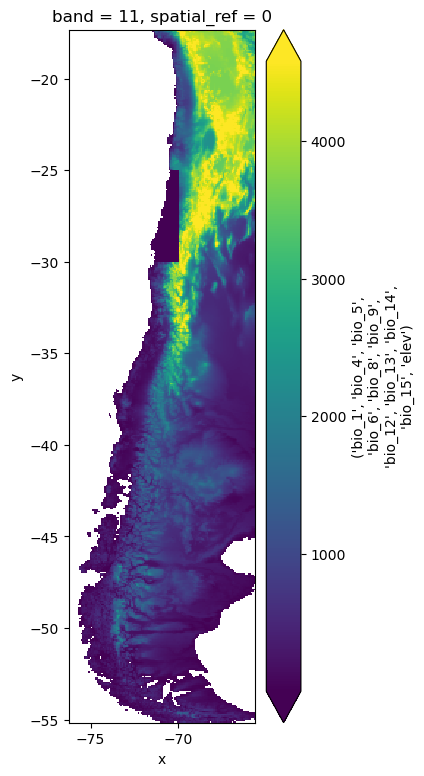

In [26]:
xds.sel(band=11).plot.imshow(figsize=(3, 9), robust=True)

### Compute the dissimilarity index

For each location where we have predictor variables we compute the dissimilarity index relative to the training data. 

Let's extract the predictor variables out of the `GeoDataFrame` and store them as a NumPy `ndarray`. 

In [27]:
# drop columns not needed for model development
gdf_tmp = gdf.drop(columns=["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"])
X = gdf_tmp.drop(columns=["Species_richness"]).to_numpy(copy=True)
y = gdf_tmp.loc[:, "Species_richness"].to_numpy(copy=True)

Next, we'll iterate over each location where we have predictor variables, compute the dissimilarity index relative to the training data, and store the dissimilarity index values in a NumPy `ndarray` `di`. 

In [33]:
# empty array to store 
di_map = np.zeros((xds.shape[1], xds.shape[2]))

# compute the average dissimilarity index for the training data
# this is a one-time compute operation so do this first and pass
# dbar into compute_di() to save compute time
dbar = compute_dbar(X, False)

# iterate over each location in xds
# compute the di between the predictor
# values at the location in question and 
# the training data
for r in tqdm(range(0, xds.shape[1])):
    for c in range(0, xds.shape[2]):
        preds = xds[:, r, c]
        if np.any(np.isnan(preds)):
            di_map[r, c] = np.nan
            continue
        di_tmp = compute_di(X, np.expand_dims(preds, 0), dbar, False)[0]
        di_map[r, c] = di_tmp

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 454/454 [01:41<00:00,  4.48it/s]


Let's plot the dissimilarity index values. This is a map describing how similar predictor values at a location are to values for predictor variables in the training dataset. 

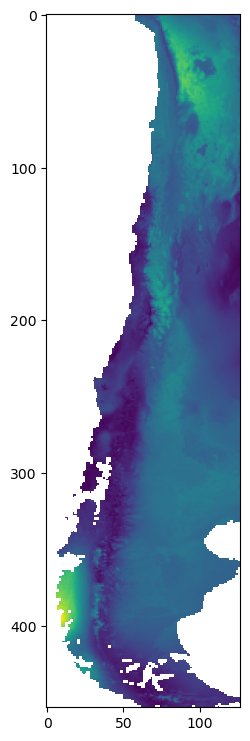

In [34]:
plt.figure(figsize=(3,9))
plt.imshow(di_map)
plt.show()

### Dissimilarity index threshold via Random k-fold cross-validation

We now have a map of dissimilarity index values for all locations where we have predictor variables. Next, we need to know what level of dissimilarity index values implies that the values of the predictor variables are not represented in the training data. We can estimate this threshold using k-fold cross-validation with the training data and compute the outlier-removed maximum dissimilarity index for all locations in the hold-out folds. Any dissimilarity index value less than this threshold in the predictors dataset is within the area of applicability for the model. 

Let's compute the dissimilarity index threshold using random k-fold cross-validation. 

In [39]:
# columns not used for model training
cols_to_drop = ["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"]

# Note, we pass in False to the spatial_cv argument
di = compute_di_theshold(gdf, 10, None, False, "Species_richness", cols_to_drop)

In [40]:
print(f"The DI threshold computed with random k-fold cross-validation: {di['di_threshold']}")

The DI threshold computed with random k-fold cross-validation: 0.18452676699355994


We can use this threshold to highlight locations outside the area of applicability in the predictors dataset.

In [41]:
outside_aoa = di_map > di["di_threshold"]

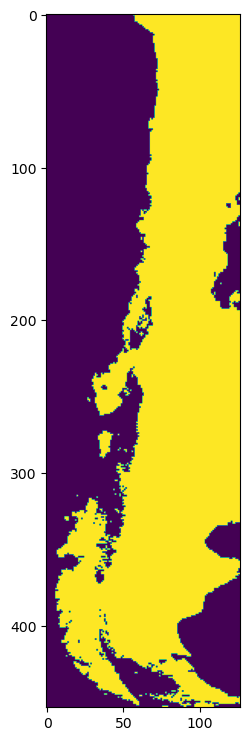

In [42]:
plt.figure(figsize=(3,9))
plt.imshow(outside_aoa)
plt.show()

### Spatial k-fold cross-validation

Next, let's compute the dissimilarity index threshold using spatial k-fold cross-validation.

In [43]:
# columns not used for model training
cols_to_drop = ["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"]

# Note, we pass in True to the spatial_cv argument
di = compute_di_theshold(gdf, 10, None, True, "Species_richness", cols_to_drop)

In [44]:
print(f"The DI threshold computed with spatial k-fold cross-validation: {di['di_threshold']}")

The DI threshold computed with spatial k-fold cross-validation: 1.523773440847747


Map the locations outside the area of applicability when the dissimilarity index threshold is computed using spatial k-fold cross-validation. 

In [47]:
outside_aoa_sp_cv = di_map > di["di_threshold"]

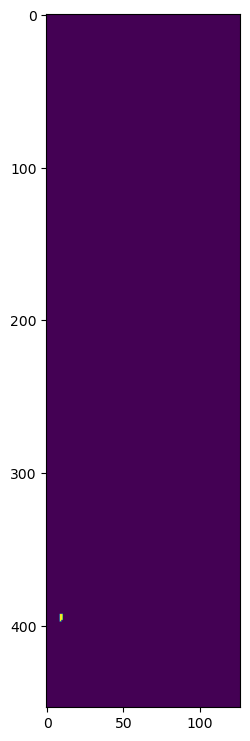

In [48]:
plt.figure(figsize=(3,9))
plt.imshow(outside_aoa_sp_cv)
plt.show()

Depending on whether we use random or spatial k-fold cross-validation we get very different estimates of the dissimilarity index threshold and the area of applicability for the machine learning model. 

#### Activity!

<details>
    <summary><strong>Why is the dissimilarity index threshold higher and the area of applicability lower when estimated using spatial k-fold cross-validation?</summary>
    
Spatial k-fold cross-validation splits the training data into spatial clusters and holds out each cluster in-turn. This strategy to splitting the data creates larger distances between training and test folds which mimics the situation of evaluating a model when deployed far away from the locations of the training data. Thus, assuming the predictor values in the training data are spatially correlated, it is likely that there will be higher dissimilarity values between locations in the training and test folds. This, in turn, will return a higher dissimilarity index threshold.

If the training data has a degree of spatial clustering, creating hold out folds using random k-fold cross-validation will mean that examples in a hold-out fold are likely close in space to examples in a training fold. Thus, the dissimilarity index values between training and hold-out folds will be smaller and the dissimilarity index threshold will also be smaller. This means we're only able to assess the model's application close to locations in the training dataset. Therefore, the area of application will be much  smaller. 

The trade-off is while using spatial k-fold cross-validation will result in a larger area of application for the machine learning model there will be a corresponding larger model error estimate.

</details>

<p></p>
Let's explore the relationship between model error and the dissimilairty index further. 

## Relationship between dissimilarity index and model error

We would expect model error to increase as the dissimilarity index increases reflecting a situations where the predictor data is less similar to values in the training dataset. <a href="https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.13650" target="_blank">Meyer and Pebesma (2021)</a> outline an approach for exploring the relationship between the dissimilarity index and model error:

1. Iterate over a list of $n$ folds:
    * Implement k-fold cross-validation with $n_{k}$ folds.
    * Compute the dissimilarity index for all examples in the hold-out folds.
    * Compute the error for each prediction in the hold-out folds. 
2. Sort the dissimilarity index values in ascending order.
3. Compute the RMSE of predictions on the hold-out folds in moving window of size 10.
4. Plot dissimilarity index values against RMSE computed within moving windows.

Let's quickly create a helper function the implements these steps:

In [50]:
def di_model_error(gdf, spatial_cv, target, cols_to_drop):
    """Plot the relationship between dissimilarity index and model error
    
    Args:
        gdf (GeoDataFrame): The spatial dataset (GeoDataFrame) containing features and the target variable.
        spatial_cv (bool): If `True`, use k-fold spatial cross-validation. Otherwise, use k-fold random cross-validation.
        target_column (str): The column name for the target variable.
        cols_to_drop (list): Columns to drop that should not be included as predictors.

    Returns:
        scatter plot visualising the relationship between the dissimilarity index and model error. 
    """
    # set up a model
    model = MLPRegressor(hidden_layer_sizes=(50,), random_state=4, solver="sgd", max_iter=500)
        
    # loop over k-fold validation with different numbers of folds
    di_preds = []
    for f in [3, 5, 10, 20, 30]:
        di_preds.append(compute_di_theshold(gdf, f, model, spatial_cv, target, cols_to_drop))

    # create a DataFrame of DI values and squared errors
    di_preds_df = pd.DataFrame()
    
    for i in di_preds:
        tmp_df = pd.DataFrame({
            "DI": i["di"],
            "squared_error": np.abs(i["errors"]) * np.abs(i["errors"])
        })
    
        di_preds_df = pd.concat([di_preds_df, tmp_df], axis=0, ignore_index=True)
    
    # sort the DataFrame by DI values
    di_preds_sorted = di_preds_df.sort_values(by=["DI"], ascending=True).reset_index(drop=True)
    
    # compute the RMSE within moving window over ascending DI values
    window_size = 10
    
    # Calculate rolling RMSE
    di_preds_sorted.loc[:, "RMSE"] = (
        di_preds_sorted.loc[:, "squared_error"]
        .rolling(window=window_size)
        .apply(lambda x: np.sqrt(np.mean(x)), raw=True)
    )

    sns.regplot(data=di_preds_sorted, x="DI", y="RMSE", lowess=True)

Now we can plot the relationship between the dissimilarity index and cross-validation error using spatial k-fold cross-validation. We can see there is an increasing trend indicating that as the dissimilarity between prediction locations and the training data increases the model error also increases. 

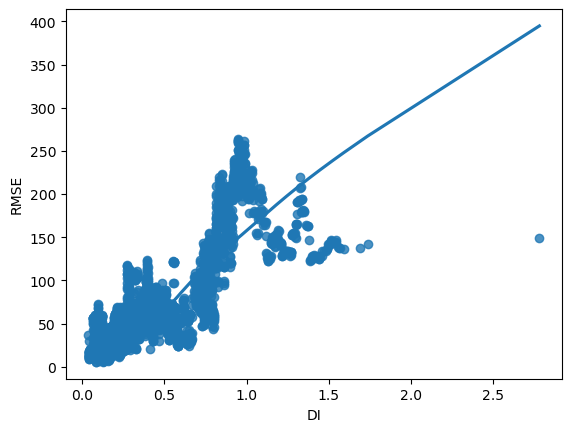

In [51]:
# columns not used for model training
cols_to_drop = ["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"]

# set spatial_cv to True for spatial k-fold cross-validation
di_model_error(gdf, True, "Species_richness", cols_to_drop)

If we use random k-fold cross-validation instead of spatial k-fold cross-validation you will note the relationship between the dissimilarity index and model perror persists. However, we have a smaller range of dissimilarity index values and lower model error estimates. 

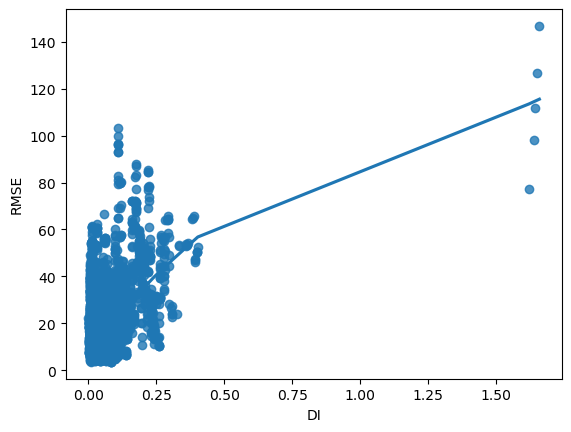

In [52]:
# columns not used for model training
cols_to_drop = ["PlotObservationID", "GIVD_ID", "Country", "Biome", "geometry"]

# set spatial_cv to False for random k-fold cross-validation
di_model_error(gdf, False, "Species_richness", cols_to_drop)